# QCut Basic Usage

In [1]:
import QCut as ck
from QCut import cut, cutCZ
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator
from iqm.qiskit_iqm import IQMFakeAdonis

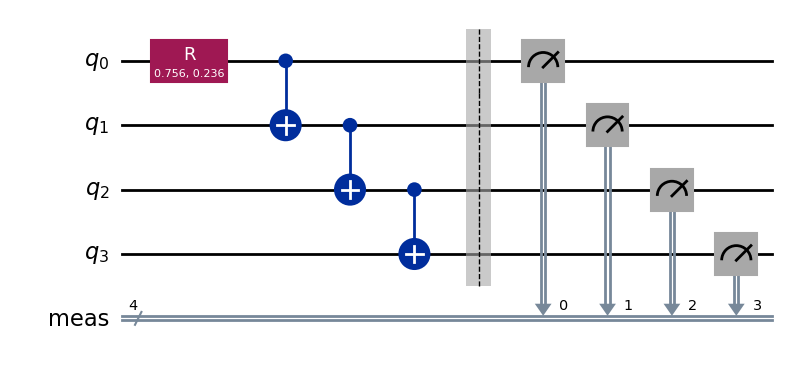

In [2]:
#define initial circuit

circuit  =  QuantumCircuit(4)

mult = 1.635
circuit.r(mult*0.46262, mult*0.1446, 0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.cx(2,3)
   
circuit.measure_all()

circuit.draw("mpl")

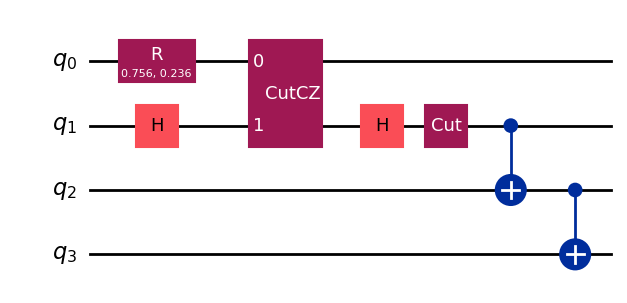

In [3]:
#insert cuts

cut_circuit = QuantumCircuit(4)

mult = 1.635
cut_circuit.r(mult*0.46262, mult*0.1446, 0)
cut_circuit.h(1)
cut_circuit.append(cutCZ, [0,1])
cut_circuit.h(1)
cut_circuit.append(cut, [1])
cut_circuit.cx(1,2)
cut_circuit.cx(2,3)

cut_circuit.draw("mpl")

In [4]:
#extract cut locations and separate into subcircuits

cut_locations, subcircuits, map_qubit = ck.get_locations_and_subcircuits(cut_circuit)

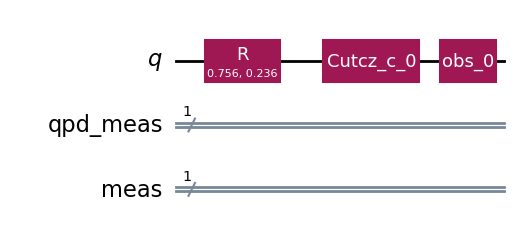

In [5]:
subcircuits[0].draw("mpl")

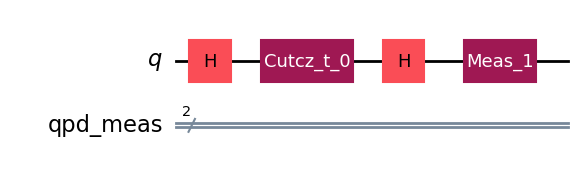

In [6]:
subcircuits[1].draw("mpl")

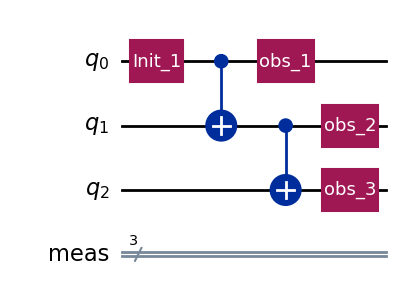

In [7]:
subcircuits[2].draw("mpl")

In [8]:
#define backends
fake = IQMFakeAdonis()
sim = AerSimulator()

In [9]:
#transpile subcircuits for backend

transpiled = ck.transpile_subcircuits(subcircuits, cut_locations, fake, optimization_level=3)

In [10]:
#generate experiment circuits
experiment_circuits, coefficients, id_meas = ck.get_experiment_circuits(transpiled, cut_locations)

In [11]:
#run experiment circuits
#run_experiments() also post processes the results

results = ck.run_experiments(experiment_circuits, cut_locations, id_meas, backend=fake)

In [12]:
#define observables to calculate expectation values for
observables = [0,1,2, [0,2]]

#get the approximated expectation values
expectation_values = ck.estimate_expectation_values(results, coefficients, cut_locations, observables, map_qubit)

In [13]:
#transform observables into a PauliList for the Qiskit Estimator
paulilist_observables = ck.get_pauli_list(observables, circuit.num_qubits)

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(paulilist_observables),  # noqa: PD011
                  list(paulilist_observables)).result().values
)

tr = transpile(circuit, backend=fake)
counts, exps = ck.run_and_expectation_value(tr, fake, observables, shots=2048)

In [14]:
import numpy as np

#set numpy print options
np.set_printoptions(formatter={"float": lambda x: f"{x:0.6f}"})
expectation_values = np.array(expectation_values).astype(float)

#compare QCut to Estimator and noisy simulation
print(f"QCut expectation values:{np.array(expectation_values)}")
print(f"Noisy expectation values with fake backend:{np.array(exps)}")
print(f"Exact expectation values with ideal simulator :{np.array(exact_expvals)}")


QCut expectation values:[0.567432 0.582619 0.629570 0.755626]
Noisy expectation values with fake backend:[0.522461 0.627930 0.553711 0.724609]
Exact expectation values with ideal simulator :[0.727323 0.727323 0.727323 1.000000]
